In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



In [2]:
# define fixed parameters

#conductances
C_m = 1.0e-9

# volatages
V_leak = -40.0e-3 # 40 mV
V_Ca = 100.0e-3 # 100mV
V_k = -80.0e-3 # -80mV
V_h = -20.0e-3 # -20mV
V_syn = -75.0e-3 # -75mV

v_1 = 0.0 # 0mV
v_2 = 20.0e-3 # 20mV
v_3 = 0.0 # 0mV
v_4 = 15.0e-3 # 15mV
v_5 = 78.3e-3 # 78.3mV
v_6 = 10.5e-3 # 10.5mV
v_7 = -42.2e-3 # -42.2mV
v_8 = 87.3e-3 # 87.3mV
v_9 = 5.0e-3  # 5.0mV

v_th = -25.0e-3 # -25mV

# neuron specific conductances
g_Ca_f = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
g_Ca_h = 1.7e-2 * (1e-6) # 1.7e-2 \mu S
g_Ca_s = 8.5e-3 * (1e-6) # 8.5e-3 \mu S

g_k_f  = 3.9e-2 * (1e-6) # 3.9e-2 \mu S
g_k_h  = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
g_k_s  = 1.5e-2 * (1e-6) # 1.5e-2 \mu S

g_h_f  = 2.5e-2 * (1e-6) # 2.5e-2 \mu S
g_h_h  = 8.0e-3 * (1e-6) # 8.0e-3 \mu S
g_h_s  = 1.0e-2 * (1e-6) # 1.0e-2 \mu S

g_Ca = np.array([g_Ca_f, g_Ca_f, g_Ca_h, g_Ca_s, g_Ca_s])
g_k = np.array([g_k_f, g_k_f, g_k_h, g_k_s, g_k_s])
g_h = np.array([g_h_f, g_h_f, g_h_h, g_h_s, g_h_s])

g_leak = 1.0e-4 * (1e-6) # 1e-4 \mu S

phi_N = 2 # 0.002 ms^-1


    

## state representation

The state variable $x$ is comprised of three, five-dimensional state variables ($V_m$, $N$, and $H$) for each neuron.

$$x = \begin{bmatrix} V_m \\ N \\ H \end{bmatrix}$$
$$V_m = \begin{bmatrix} V_{m,f_1} \\ V_{m,f_2} \\ V_{m,h_n} \\ V_{m,s_1} \\ V_{m,s_2} \end{bmatrix} \hspace{1cm}
N = \begin{bmatrix} N_{f_1} \\ N_{f_2} \\ N_{h_n} \\ N_{s_1} \\ N_{s_2} \end{bmatrix} \hspace{1cm}
H = \begin{bmatrix} H_{f_1} \\ H_{f_2} \\ H_{h_n} \\ H_{s_1} \\ H_{s_2} \end{bmatrix} 
$$

In [3]:

def f(x, g_el, g_synA, g_synB):
    # x contains
    V_m = x[:5]
    N = x[5:10]
    H = x[10:]
    
    M_inf = 0.5*(1.0 + np.tanh((V_m - v_1)/ v_2))
    N_inf = 0.5*(1.0 + np.tanh((V_m - v_3)/v_4))
    H_inf = 1.0 / (1.0 + np.exp((V_m + v_5)/v_6))
                   
    S_inf = 1.0 / (1.0 + np.exp((v_th - V_m) / v_9))
    
    I_leak = g_leak*(V_m - V_leak)
    I_Ca = g_Ca*M_inf*(V_m - V_Ca)
    I_k = g_k*N*(V_m - V_k)
    I_h = g_h*H*(V_m - V_h)
                   
    I_elec = np.array([0.0, 
                       g_el*(V_m[1]-V_m[2]),
                       g_el*(V_m[2]-V_m[1] + V_m[2]-V_m[4]),
                       0.0,
                       g_el*(V_m[4]-V_m[2])])
                   
    I_syn = np.array([g_synB*S_inf[1]*(V_m[0] - V_syn),
                        g_synB*S_inf[0]*(V_m[1] - V_syn),
                        g_synA*S_inf[0]*(V_m[2] - V_syn) + g_synA*S_inf[3]*(V_m[2] - V_syn),
                        g_synB*S_inf[4]*(V_m[3] - V_syn),
                        g_synB*S_inf[3]*(V_m[4] - V_syn)])

    I_total = I_leak + I_Ca + I_k + I_h + I_elec + I_syn    
    
    lambda_N = (phi_N)*np.cosh((V_m - v_3)/(2*v_4))
    tau_h = (272.0 - (-1499.0 / (1.0 + np.exp((-V_m + v_7) / v_8)))) / 1000.0
    
    dVmdt = (1.0 / C_m)*(-I_total)
    dNdt = lambda_N*(N_inf - N)
    dHdt = (H_inf - H) / tau_h
    
    dxdt = np.concatenate((dVmdt, dNdt, dHdt), axis=0)
    return dxdt
                   

In [79]:
# parameters for the DSN
g_el = 6.0 * (1e-9) # .25 nS  (.25-7.5 nS) range
g_synA = 4.0 * (1e-9) # .25 nS  (.25-10 nS) range
g_synB = 5.0 * (1e-9) # .25 nS  (.25-10 nS) range

x_test = np.array(np.random.normal(0.0, 1.0, (15,)))

dxdt = f(x_test, g_el, g_synA, g_synB)
print(dxdt)


[-8.04255841e+00  1.10706684e+01 -5.18621966e+00 -1.76645017e+01
  4.38633223e-01  4.12800171e+02 -1.13470206e+03 -6.30587864e-01
  1.92977444e+09  1.31472698e+02  3.55959384e+00 -3.91229333e-01
 -8.68390404e-01 -4.50047789e-01  2.50816820e+00]


In [80]:
V_m0 = -65.0e-3*np.ones((5,))
N_0 = 0.25*np.ones((5,))
H_0 = 0.1*np.ones((5,))
x0 = np.concatenate((V_m0, N_0, H_0), axis=0)
#x0 = np.array([0.7, -0.5, -0.5, 0.7, -0.7, \
#               0.05, 0.05, 0.035, 0.035, 0.035, \
#               0.1, 0.1, 0.1, 0.1, 0.1])
xs = [x0]
x = x0
T = 500
dt = 0.05

fft_start = 50

freqs = np.fft.fftfreq(T) / dt
print('freqs', freqs)
freqs = np.fft.fftfreq(T-fft_start+1) / dt
print('freqs fft', freqs)

for t in range(T):
    dxdt = f(x, g_el, g_synA, g_synB)
    x = dxdt*dt + x
    xs.append(x)
X = np.array(xs)
print(X.shape)

freqs [  0.     0.04   0.08   0.12   0.16   0.2    0.24   0.28   0.32   0.36
   0.4    0.44   0.48   0.52   0.56   0.6    0.64   0.68   0.72   0.76
   0.8    0.84   0.88   0.92   0.96   1.     1.04   1.08   1.12   1.16
   1.2    1.24   1.28   1.32   1.36   1.4    1.44   1.48   1.52   1.56
   1.6    1.64   1.68   1.72   1.76   1.8    1.84   1.88   1.92   1.96
   2.     2.04   2.08   2.12   2.16   2.2    2.24   2.28   2.32   2.36
   2.4    2.44   2.48   2.52   2.56   2.6    2.64   2.68   2.72   2.76
   2.8    2.84   2.88   2.92   2.96   3.     3.04   3.08   3.12   3.16
   3.2    3.24   3.28   3.32   3.36   3.4    3.44   3.48   3.52   3.56
   3.6    3.64   3.68   3.72   3.76   3.8    3.84   3.88   3.92   3.96
   4.     4.04   4.08   4.12   4.16   4.2    4.24   4.28   4.32   4.36
   4.4    4.44   4.48   4.52   4.56   4.6    4.64   4.68   4.72   4.76
   4.8    4.84   4.88   4.92   4.96   5.     5.04   5.08   5.12   5.16
   5.2    5.24   5.28   5.32   5.36   5.4    5.44   5.48   5.52   5.56


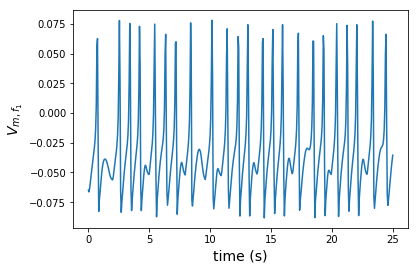

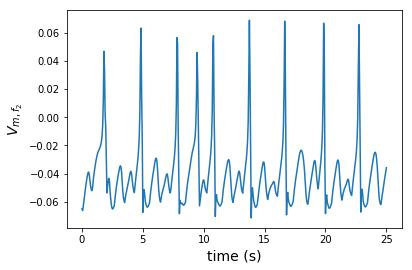

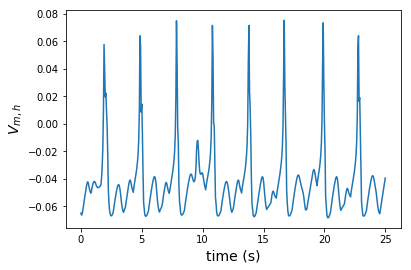

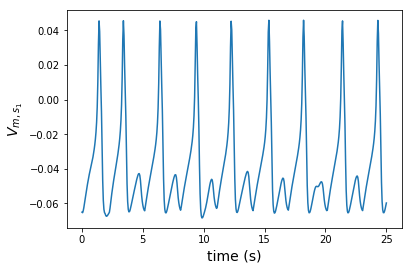

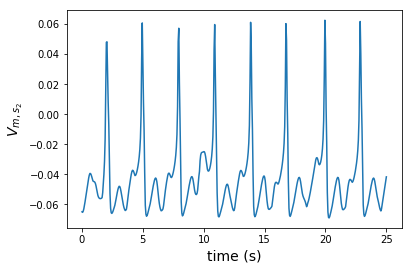

In [81]:
labels = [r'$V_{m,f_1}$', r'$V_{m,f_2}$', r'$V_{m,h}$', r'$V_{m,s_1}$', r'$V_{m,s_2}$', \
          r'$N_{f_1}$', r'$N_{f_2}$', r'$N_{h}$', r'$N_{s_1}$', r'$N_{s_2}$', \
          r'$H_{f_1}$', r'$H_{f_2}$', r'$H_{h}$', r'$H_{s_1}$', r'$H_{s_2}$']

fontsize = 14
t = np.arange(T+1) * dt
for i in range(5):
    plt.figure()
    plt.plot(t, X[:,i])
    plt.xlabel('time (s)', fontsize=fontsize)
    plt.ylabel(labels[i], fontsize=fontsize)
    plt.show()
    
x_fin = X[-1,:]

(10001,) (10001,)
neuron $V_{m,h}$ max freq 0.6999300069993001


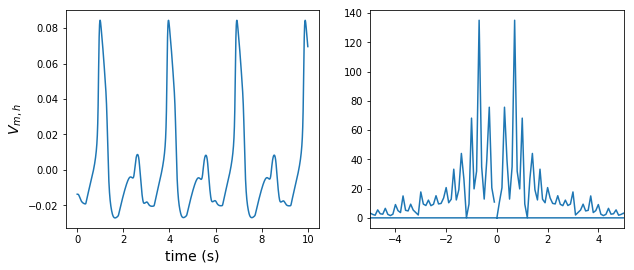

(10001,) (10001,)
neuron $V_{m,h}$ max freq 0.6999300069993001


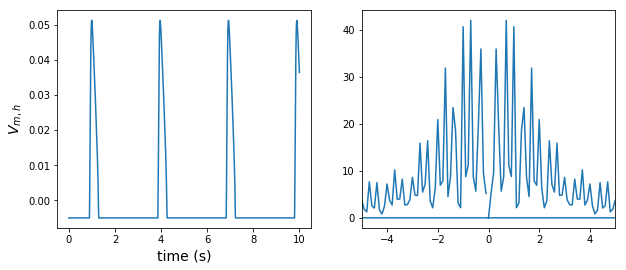

(9502,) (9502,)
neuron $V_{m,h}$ max freq 0.3157230056830141


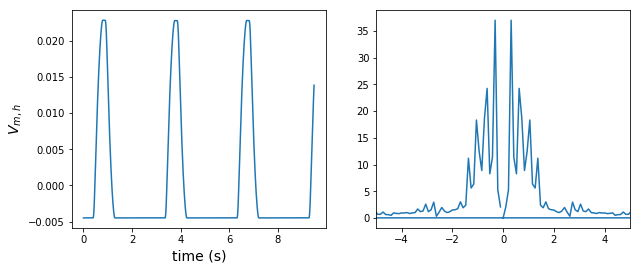

In [57]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

neuron_ind = 2
X_end = X[fft_start:,neuron_ind]
X_end_mc = X_end - np.mean(X_end)

X_rect = np.maximum(X_end, -0.01)
X_rect_mc = X_rect - np.mean(X_rect)

w = 500
X_rect_LPF = moving_average(X_rect, w)
X_rect_LPF_mc = X_rect_LPF - np.mean(X_rect_LPF)

Xs = [X_end_mc, X_rect_mc, X_rect_LPF_mc]

freqs = np.fft.fftfreq(N) / dt
t = np.arange(0.0, N*dt, dt)
ts = [t, t, t[:N-(w-1)]]
for i in range(len(Xs)):
    x = Xs[i]
    _t = ts[i]
    print(x.shape, _t.shape)
    Xfft = np.abs(np.fft.fft(x))
    ind = np.argmax(Xfft)
    freqs = np.fft.fftfreq(x.shape[0]) / dt

    print('neuron', labels[neuron_ind], 'max freq', freqs[ind])

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(_t, x)
    plt.xlabel('time (s)', fontsize=fontsize)
    plt.ylabel(labels[neuron_ind], fontsize=fontsize)
    plt.subplot(1,2,2)
    plt.plot(freqs, Xfft)
    plt.xlim([-5, 5])
    plt.show()

i 0 max freq 0.6999300069993001
(10001,) (10001,)


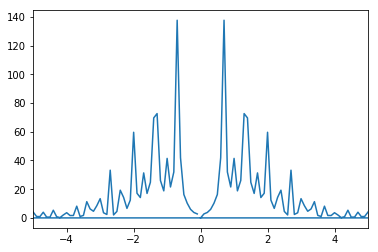

i 1 max freq 0.6999300069993001
(10001,) (10001,)


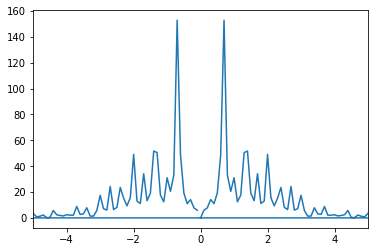

i 2 max freq 0.6999300069993001
(10001,) (10001,)


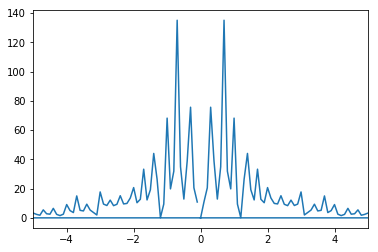

i 3 max freq 0.2999700029997
(10001,) (10001,)


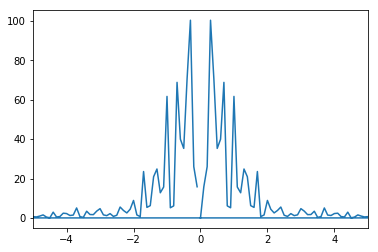

i 4 max freq 0.6999300069993001
(10001,) (10001,)


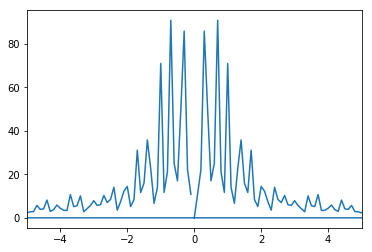

In [58]:
fft_start = 4000
N = T - fft_start+ 1
for i in range(5):
    X_end = X[fft_start:,i]
    X_end_mc = X_end - np.mean(X_end)

    Xfft = np.abs(np.fft.fft(X_end_mc))

    freqs = np.fft.fftfreq(N) / dt
    ind = np.argmax(Xfft)
    
    print('i', i, 'max freq', freqs[ind])
    print(freqs.shape, Xfft.shape)
    plt.figure()
    plt.plot(freqs, Xfft)
    plt.xlim([-5, 5])
    plt.show()

In [21]:
x = np.random.normal(0.0, 1.0, (4, 10))
print(x)
y = np.maximum(x, 0.0)
print(y)

[[-0.85222844  0.58861233  0.57187986  2.20826515 -0.45091852  1.23861145
  -0.81454759  0.33472992  0.64091435  0.00552596]
 [-1.04178881  1.20747592  0.22570211 -0.01226135  1.24109204 -1.23854894
  -0.78218174  0.5955427  -1.73614278 -1.52781076]
 [-2.34466964 -0.77687346 -1.29471416  0.06746301 -0.7156409  -0.89461487
   1.10593251  0.2598018   0.61238723  1.28056417]
 [-0.78691652  1.14786847  0.17299144 -1.83029835 -1.08828711  0.85590835
  -1.1149521   2.46646675  1.17153331  0.09133651]]
[[0.         0.58861233 0.57187986 2.20826515 0.         1.23861145
  0.         0.33472992 0.64091435 0.00552596]
 [0.         1.20747592 0.22570211 0.         1.24109204 0.
  0.         0.5955427  0.         0.        ]
 [0.         0.         0.         0.06746301 0.         0.
  1.10593251 0.2598018  0.61238723 1.28056417]
 [0.         1.14786847 0.17299144 0.         0.         0.85590835
  0.         2.46646675 1.17153331 0.09133651]]


In [ ]:
labels = ['f1', 'f2', 'hub', 's1', 's2']

fontsize = 14
t = np.arange(T+1) * dt
for i in range(15):
    fig = plt.figure(figsize=(6, 2))
    plt.plot(t, X[:,i], 'k-', linewidth=1.5)
    plt.xlabel('time (s)', fontsize=fontsize)
    plt.xlim([4, 14])
    plt.axis('off')
    if (i < 5):
        plt.savefig('/Users/sbittner/Documents/dsn/written/Journal2019/figs/fig1/STG_behavior_%s.png' % labels[i])
    #fig.patch.set_visible(False)
    plt.show()
    
    
